In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import coo_matrix
import sklearn.preprocessing as pre
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier,Pool

from datetime import datetime
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.core.display import HTML
import json
import pickle, time

from hyperopt import fmin, tpe, Trials, STATUS_OK, STATUS_FAIL, hp, pyll
#from hyperopt import pyll
import csv
#from sklearn.ensemble import GradientBoostingClassifier as GBC

%load_ext line_profiler

### Bayesian Optimization: feature selections

In [2]:
def load_data(klas=1):
    #### load data file
    data=pd.read_csv('orange_small_test.data',header=0,delimiter='\t')
    #### Load label files
    labels=dict({
    1 : pd.read_csv('orange_small_train_appetency.labels',header=None,delimiter='\t'),
    2 : pd.read_csv('orange_small_train_churn.labels',header=None,delimiter='\t'),
    3 : pd.read_csv('orange_small_train_upselling.labels',header=None,delimiter='\t')
    })
           
    lbl=labels[klas]
    idx=np.where(lbl!=klas)
    lbl.at[idx[0],0]=0
    
    return data, lbl

In [5]:
def data_preparation():
    klas=1
    #load data
    x,y=load_data(klas)
    
    #drop empty cols
    drop_cols=[]
    for col, isEmpty in (x.describe().T['count']==0).items():
        if isEmpty:
            drop_cols.append(col)
            #print(col)
    #x=x.drop(drop_cols,axis=1)
    col_num=[]
    col_cat=[]
    for col, typ in x.dtypes.items():
        if typ == np.object:
            col_cat.append(col)
        else:
            col_num.append(col)
    for col in col_cat:
        x[col].fillna('?',inplace=True)       
    
    col_app=[]
    
    for col in col_num:
        x[col +"_imputed"]=pd.isnull(x[col]).astype('float')
        col_app.append(col +"_*")
        x[col].fillna(0,inplace=True)
    
    #col_num=col_num+col_app
    col_cat=col_cat+col_app
    
    xtrain,xtest,ytrain,ytest=train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
    print('train data: ',xtrain.shape[0])
    print('train data class: ',(ytrain==1)[0].sum())
    print('test data: ', xtest.shape[0])
    print('test data class: ', (ytest==1)[0].sum())
    print('test/train class ratios:',(ytest==1)[0].sum()/(ytrain==1)[0].sum())
    
    xtrain_cat=xtrain.loc[:,col_cat]
    xtrain_num=xtrain.loc[:,col_num]
    xtest_cat=xtest.loc[:,col_cat]
    xtest_num=xtest.loc[:,col_num]
    
    data=dict({
        'category_columns':col_cat,
        'numeric_columns':col_num,
        'train_cat':xtrain_cat,
        'test_cat':xtest_cat,
        #'train_tbs':xtrain_cat_tbs,
        #'test_tbs':xtest_cat_tbs,
        'train_num':xtrain_num,
        'test_num':xtest_num,
        #'train_norm':xtrain_norm,
        #'test_norm':xtest_norm,
        'y_train':ytrain,
        'y_test':ytest
    }
    )
    return data

In [6]:
%%time
data=data_preparation()

train data:  45000
train data class:  801
test data:  5000
test data class:  89
test/train class ratios: 0.1111111111111111


C:\Users\h_agu\Desktop\machine_learning\Miniconda3\envs\tensorflow-gpu3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Wall time: 3.38 s


In [6]:
def set_parameters(iterations=201,
        depth=6,
        thread_count=8,
        learning_rate=0.03,
        loss_function='Logloss',
        fold_len_multiplier = 2,
        rsm = 1,
        border_count = 128,
        max_ctr_complexity = 2,
        l2_leaf_reg = 3,
        leaf_estimation_method = 'Newton',
        leaf_estimation_iterations = 10,
        random_strength = 1,
        one_hot_max_size = 0,
        bagging_temperature = 1,
        logging_level = 'Verbose',
        eval_metric = 'AUC',
        custom_loss = ['Accuracy','Precision','Recall'],
        random_seed=300,
        metric_period=50,
        calc_feature_importance = True,
        task_type = 'CPU',
        #class_weights = (1,4)
              ):
    params=dict(iterations=iterations,
        depth=depth,
        thread_count=thread_count,
        learning_rate=learning_rate,
        loss_function=loss_function,
        fold_len_multiplier = fold_len_multiplier,
        rsm = rsm,
        border_count = border_count,
        max_ctr_complexity=max_ctr_complexity,
        l2_leaf_reg = l2_leaf_reg,
        leaf_estimation_method = leaf_estimation_method,
        leaf_estimation_iterations = leaf_estimation_iterations,
        random_strength = random_strength,
        one_hot_max_size = one_hot_max_size,
        bagging_temperature = bagging_temperature,
        #ctr_description = 'Borders',
        logging_level = logging_level,
        eval_metric = eval_metric,
        #train_dir=strnow,
        custom_loss = custom_loss,
        random_seed=random_seed,
        metric_period=metric_period,
        calc_feature_importance = metric_period,
        task_type=task_type,
        #class_weights=class_weights
               )
    return params
params=set_parameters(eval_metric='AUC')

In [7]:
def split_pair(x,y,n_splits=5,klas=1, cat_cols=[]):
    #global col_cat
    split_pair=[]
    split_pair_raw=[]
    split=StratifiedKFold(n_splits, shuffle=True, random_state=0)

    if len(cat_cols)>0:
        col_cat_idx=[]
        cols=x.columns.tolist()
        _=[ col_cat_idx.append(cols.index(col)) for col in cat_cols]

    for train_idx, test_idx in split.split(x,y):
        _x=x.iloc[train_idx]
        _y=y.iloc[train_idx]
        _xt=x.iloc[test_idx]
        _yt=y.iloc[test_idx]
        
        if len(cat_cols) > 0:
            trainp=Pool(_x,_y,cat_features=col_cat_idx)
            testp=Pool(_xt,_yt,cat_features=col_cat_idx)
        else:
            trainp=Pool(_x,_y)
            testp=Pool(_xt,_yt)
        split_pair.append((trainp,testp))
        #split_pair_raw.append(((trainx,trainy),(testx,testy)))
    return split_pair, split_pair_raw

In [8]:
space={'category_data': hp.choice('category',['tbs','non']),
        'numerical_data': hp.choice('numeric',['normal','non'])
                               }
param_space = {
            'depth': hp.choice('depth', [4,6,8]),
            'border_count': hp.choice('border_count', [64,128]),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),
            'random_strength': hp.choice('random_strength', [1,  20]),
            'one_hot_max_size': hp.choice('one_hot_max_size', [0, 25]),
            'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, np.log(10)),
            'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
            'leaf_estimation_iterations':hp.choice('leaf_estimation_iterations',[1,3,5,7,10])
            #'class_weights': (hp.uniform('non_class_weights_ratio',0.5,1), hp.uniform('class_weights_ratio',1,10))
        }

space.update({'param_space':param_space})
feature_space={}
cols=data['category_columns']+data['numeric_columns']
_=[feature_space.update({col : eval("hp.choice('"+ col + "',[0,1])")}) for col in cols]

space.update({'feature_space':feature_space})
#space.update({'data':data})

In [10]:
def fit(params=None, dtrain=None, dtest=None, n_estimators=None, seed=0, run_time=None, run_cv_id=0, eval_no=0):
    global metric,column_names
    #print(run_cv_id, eval_no)
    path="./cv_run/"+str(run_time)
    if not os.path.isdir(path):
        os.mkdir(path)
    fpath=path+"/"+str(eval_no)+"."+str(run_cv_id)
    if not os.path.isdir(fpath):
        os.mkdir(fpath)    
    params.update({"iterations": n_estimators})
    params.update({"eval_metric": metric})
    params.update({"logging_level": 'Silent'})
    #params.update({"metric_period": 100})
    params.update({"random_seed": seed})
    #params.update({"leaf_estimation_method": "Newton"})
    #params.update({"leaf_estimation_iterations" : 10})
    params.update({"rsm" : 1})
    params.update({"thread_count" : 8})
    params.update({"fold_len_multiplier": 2})
    #params.update({"max_ctr_complexity":5})
    params.update({"train_dir": fpath})
    params.update({"calc_feature_importance" : True})
    params.update({'od_type':'Iter'})
    params.update({'od_wait':30})
    
    bst = CatBoostClassifier(**params)
    bst.fit(dtrain, eval_set=dtest, use_best_model=True)
    with open(fpath + "/test_error.tsv", "r") as f:
        reader=np.array(list(csv.reader(f,delimiter='\t'))).squeeze()
    header=reader[0]
    feature=dict()
    for col, val in zip(column_names,bst.__dict__['_feature_importance']):
        feature.update({col:val})
    #pd.to_pickle(bst.__dict__['_feature_importance'],path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    pd.to_pickle(feature,path+"/feature_importance."+str(eval_no)+"."+str(run_cv_id))
    idx=(header==metric).argmax()
    results=(reader[1:reader.shape[0],idx]).astype(np.float)
    return bst, 1-results

In [11]:
def mean_each_iter(results):
    lengs=[]
    _=[lengs.append(len(res)) for res in results]
    mlen=np.max(lengs)
    #print(lengs,mlen)
    a=[]
    for run in results:
        a.append((np.pad(run,(0,mlen-len(run)),'constant')).tolist())
    x=np.array(a)
    #print(x.shape)
    means=[]
    for i in range(x.shape[1]):
        mean=0
        count=0
        for j in range(x.shape[0]):
            if x[j,i] > 0:
                count=count+1
                mean=mean+x[j,i]
        means.append(mean/count)
    return means

In [12]:
def run_cv(cv_pairs, params=None, n_est=None, verbose=False, run_time=None):
    global default_params,n_estimators,best_loss,hyperopt_eval_num,metric,hyperopt_evals
    params = params or default_params
    n_estimators = n_est or n_estimators
    #print('run_cv',hyperopt_eval_num)
    evals_results, start_time = [], time.time()
    _loss=[]
    i=0
    for dtrain, dtest in cv_pairs:
        _, evals_result = fit(params, dtrain, dtest, n_estimators, run_time=run_time, run_cv_id=i, eval_no=hyperopt_eval_num+1)
        #evals_results.append(np.mean(evals_result,axis=0))
        evals_results.append(evals_result)
        _loss.append(np.min(evals_result))
        i=i+1
    mean_evals_results = mean_each_iter(evals_results)
    best_n_estimators = np.argmin(mean_evals_results) + 1
    eval_time = time.time() - start_time
    
    
    cv_result = {'loss': mean_evals_results[best_n_estimators - 1] ,
                 'best_n_estimators': best_n_estimators, 
                 'eval_time': eval_time,
                 'status': STATUS_FAIL if np.isnan(mean_evals_results[best_n_estimators - 1]) else STATUS_OK,
                 'params': params.copy(),
                 'losses': _loss
                }
    best_loss = min(best_loss, cv_result['loss'])
    hyperopt_eval_num += 1
    cv_result.update({'hyperopt_eval_num': hyperopt_eval_num, 'best_loss': best_loss})
        
    if verbose:
        print ('[{0}/{1}]\teval_time={2:.2f} sec\tcurrent_{3}={4:.6f}\tmin_{3}={5:.6f}'.format(
                    hyperopt_eval_num, hyperopt_evals, eval_time,
                    metric, cv_result['loss'], best_loss))
    return cv_result

In [13]:
def run_hyper_test(args,data,run_time):
    global param,hyperopt_eval_num,best_loss,column_names
    
    #cols=data['category_columns']+data['numeric_columns']
    y_train=data['y_train']
    y_test=data['y_test']
    
    if args['numerical_data'] == 'normal':
        x_train_num=data['train_norm']
        x_test_num=data['test_norm']
    else:
        x_train_num=data['train_num']
        x_test_num=data['test_num']
    
    if args['category_data'] == 'tbs':
        x_train_cat=data['train_tbs']
        x_test_cat=data['test_tbs']

    else:
        x_train_cat=data['train_cat']
        x_test_cat=data['test_cat']
        
    x_train=pd.concat([x_train_num,x_train_cat],axis=1)
    x_test=pd.concat([x_test_num,x_train_cat],axis=1)
    columns_pd=x_train.columns.tolist()
    
    feature_idx=[]
    columns_hy=[]
    _columns_selected=[]

    for col , isSelect in args['feature_space'].items():
        #isSelect=pyll.stochastic.sample(isSelect)
        feature_idx.append(isSelect)
        columns_hy.append(col)
        if isSelect:
            _columns_selected.append(col)  
            
    #reorder columns_selected
    columns_selected=[]
    _=[columns_selected.append(col) for col in columns_pd if col in _columns_selected]
            
    x_train=x_train[columns_selected]
    x_test=x_test[columns_selected]
    column_names=columns_selected
    
    #print(args['category_data'])
    if args['category_data'] == 'tbs':
        split_pair_data,_=split_pair(x_train,y_train)
        #@rint('split')
    else :
        cols=[]
        _=[cols.append(col) for col in x_train_cat.columns if col in columns_selected]
        split_pair_data,_=split_pair(x_train,y_train,cat_cols=cols)

    #hyperopt_eval_num, best_loss = 0, np.inf
    
    params= args['param_space']
    cv_result=run_cv(split_pair_data,params=params,run_time=run_time,verbose=True)
    cv_result.update({'category_data': args['category_data']})
    cv_result.update({'features': args['feature_space']})
        
    return cv_result

In [ ]:
def run_selected_feature(args,data,run_time, max_eval=10):
    global param,hyperopt_eval_num,best_loss,column_names
    
   
    y_train=data['y_train']
    y_test=data['y_test']

    if args['numerical_data'] == 'normal':
    x_train_num=data['train_norm']
        x_test_num=data['test_norm']
    else:
        x_train_num=data['train_num']
        x_test_num=data['test_num']

    if args['category_data'] == 'tbs':
        x_train_cat=data['train_tbs']
        x_test_cat=data['test_tbs']
    else:
        x_train_cat=data['train_cat']
        x_test_cat=data['test_cat']

    x_train=pd.concat([x_train_num,x_train_cat],axis=1)
    x_test=pd.concat([x_test_num,x_train_cat],axis=1)
    columns_pd=x_train.columns.tolist()

    feature_idx=[]
    columns_hy=[]
    _columns_selected=[]
    
    column_names=columns_pd
        
    split_pair_data,_=split_pair(x_train,y_train,cat_cols=x_train_cat.columns.tolist())

    params= args['param_space']
    cv_result=run_cv(split_pair_data,params=params,run_time=run_time,verbose=True)
    cv_result.update({'category_data': args['category_data']})

    return cv_result

n_estimators=50
hyperopt_evals=0
metric="AUC"
evals_results=[]
space_sample=pyll.stochastic.sample(space2)
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
params=None
hyperopt_eval_num, best_loss = 0, np.inf
res=run_hyper_test2(space_sample,data,run_time)

In [16]:
n_estimators=201
hyperopt_evals=0
metric="AUC"
max_evals = 4
this_trials = Trials()
run_time=(datetime.now()).strftime('%Y%m%d%H%M')
hyperopt_eval_num, best_loss, split_pair_data = 0, np.inf, None
args=space2 #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_hyper_test2(args,data,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/0]	eval_time=88.76 sec	current_AUC=0.461462	min_AUC=0.461462
[2/0]	eval_time=515.37 sec	current_AUC=0.474463	min_AUC=0.461462
[3/0]	eval_time=277.52 sec	current_AUC=0.462160	min_AUC=0.461462
[4/0]	eval_time=539.99 sec	current_AUC=0.480001	min_AUC=0.461462


for key, val in (t['result']['features']).items():
    if t['misc']['vals'][key][0] != val:
        print( key, t['misc']['vals'][key][0], val)

In [19]:
n_estimators=401

metric="AUC"
to_run=8

run_time_saved='201808031235'
run_time=(datetime.now()).strftime('%Y%m%d%H%M')

with open('./cv_run/'+run_time_saved+'/trails.pickle','rb') as f:
    this_trials=pickle.load(f)
    max_evals=to_run+len(this_trials.trials)
    #print(max_evals)
#this_trials=this_trials
#max_evals = max_evals + to_run # last run + # additional run
hyperopt_evals=len(this_trials.trials)

hyperopt_eval_num, best_loss = 0, this_trials.best_trial['result']['loss']
args=space2 #or pyll.stochastic.sample(space)
_ = fmin(fn=lambda args: run_hyper_test2(args,data,run_time=run_time), 
         space=args, algo=tpe.suggest, max_evals=max_evals, trials=this_trials)

with open('./cv_run/'+run_time+'/trails.pickle','wb') as f:
    pickle.dump(this_trials,f)

[1/4]	eval_time=265.51 sec	current_AUC=0.478115	min_AUC=0.445421
[2/4]	eval_time=123.29 sec	current_AUC=0.493398	min_AUC=0.445421
[3/4]	eval_time=57.36 sec	current_AUC=0.468019	min_AUC=0.445421
[4/4]	eval_time=421.49 sec	current_AUC=0.472625	min_AUC=0.445421
[5/4]	eval_time=91.08 sec	current_AUC=0.470613	min_AUC=0.445421
[6/4]	eval_time=200.46 sec	current_AUC=0.474690	min_AUC=0.445421
[7/4]	eval_time=71.52 sec	current_AUC=0.448925	min_AUC=0.445421
[8/4]	eval_time=177.51 sec	current_AUC=0.480839	min_AUC=0.445421


In [17]:
this_trials.best_trial

{'state': 2,
 'tid': 17,
 'spec': None,
 'result': {'loss': 0.4444243416,
  'best_n_estimators': 23,
  'eval_time': 32.09568238258362,
  'status': 'ok',
  'params': {'bagging_temperature': 0.32831167622691115,
   'border_count': 64,
   'depth': 6,
   'l2_leaf_reg': 1.3499854902475807,
   'leaf_estimation_iterations': 1,
   'learning_rate': 0.08606837565787569,
   'one_hot_max_size': 25,
   'random_strength': 1,
   'iterations': 401,
   'eval_metric': 'AUC',
   'logging_level': 'Silent',
   'random_seed': 0,
   'leaf_estimation_method': 'Newton',
   'rsm': 1,
   'thread_count': 8,
   'fold_len_multiplier': 2,
   'max_ctr_complexity': 2,
   'train_dir': './cv_run/201808030907/2.4',
   'calc_feature_importance': True,
   'od_type': 'Iter',
   'od_wait': 10},
  'losses': [0.4420034569,
   0.44456801469999996,
   0.4830850537,
   0.4843827771,
   0.5185155985000001],
  'hyperopt_eval_num': 2,
  'best_loss': 0.4444243416,
  'category_data': 'non'},
 'misc': {'tid': 17,
  'cmd': ('domain_atta

In [124]:
cols=data['numeric_columns'] + data['category_columns']
features=[]
klas=1
for _dir in os.listdir("cv_run"):
    if not os.path.isdir("cv_run/"+_dir):
        continue
    for file in os.listdir("cv_run/"+_dir):
        #print(file)
        if file.startswith('feature'):
            features.append(pd.read_pickle("cv_run/"+_dir+"/"+file))

In [127]:
feature_matrix=[]
for f in features:
    matrix=[]
    for col in cols:
        try:
            matrix.append(f[col])
        except KeyError:
            matrix.append(0)
    feature_matrix.append(matrix)

loss=[]
for t in this_trials.trials:
    loss.append(t['result']['losses'])
        
loss=np.squeeze(np.array(loss))
loss=loss.flatten()
y=[]
_=[y.append(i) for i in range(len(loss))]

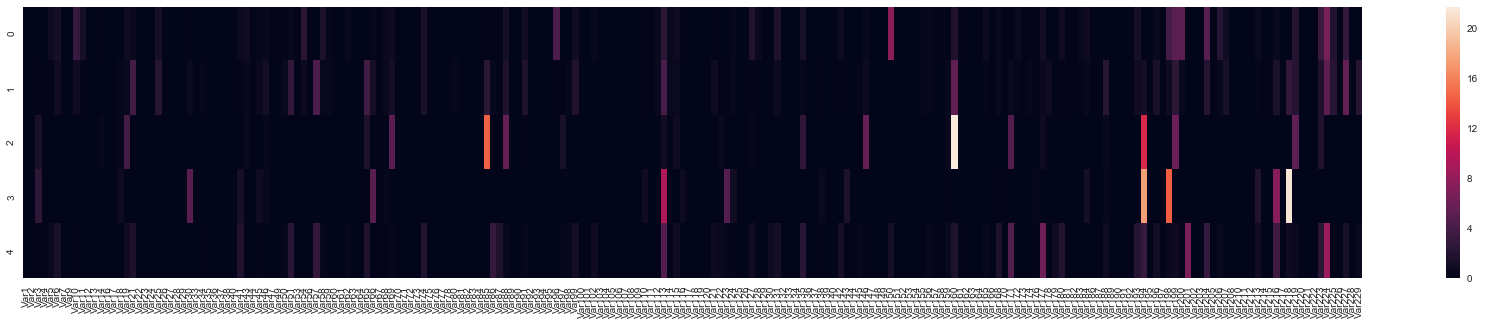

In [143]:
features=np.squeeze(np.array(feature_matrix))
plt.figure(figsize=(30,5))
ax=sns.heatmap(features[10:15,:],xticklabels=cols)
plt.show()

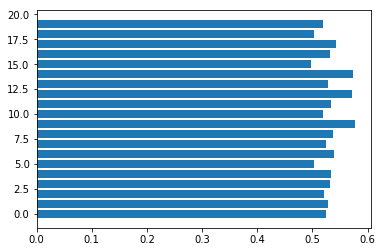

In [132]:
plt.barh(y,1-loss)
plt.show()

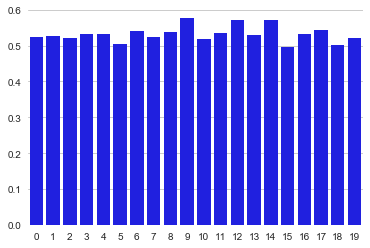

In [140]:
plt.Figure(figsize=(3,5))
sns.set(style="whitegrid")
sns.barplot(y,1-loss,color='blue')
sns.despine(left=True, bottom=True)
plt.show()